### 1. Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans  
import pylab as pl  
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [4]:
# This option ensures the graphs created are displayed in notebook without the need to "call" them specifically.

%matplotlib inline

In [6]:
path = 'C:/Users/lourd/A6_Open Project'

In [8]:
data = pd.read_excel(os.path.join(path, 'Data Sets', 'frpp_public_dataset_fy22_final_051012023.xlsx'))


In [10]:
data.shape

(307975, 113)

In [12]:
data.columns

Index(['Reporting Agency', 'Reporting Agency Code', 'Reporting Bureau',
       'Reporting Bureau Code', 'Real Property Unique Identifier',
       'Using Agency', 'Using Agency Code', 'Using Bureau',
       'Using Bureau Code', 'US/Foreign',
       ...
       'Year of Construction', 'Outgrant Indicator Value',
       'Asset Height Range', 'Asset Height',
       'Asset Height Range Above Mean Sea Level',
       'Asset Height Above Mean Sea Level', 'Elevation Above Mean Sea Level',
       'FOIA Exemption', 'FOIA Exemption Code', 'Statutory Citation'],
      dtype='object', length=113)

In [14]:
data.head

<bound method NDFrame.head of         Reporting Agency  Reporting Agency Code  \
0            AGRICULTURE                     12   
1            AGRICULTURE                     12   
2            AGRICULTURE                     12   
3            AGRICULTURE                     12   
4            AGRICULTURE                     12   
...                  ...                    ...   
307970  VETERANS AFFAIRS                     36   
307971  VETERANS AFFAIRS                     36   
307972  VETERANS AFFAIRS                     36   
307973  VETERANS AFFAIRS                     36   
307974  VETERANS AFFAIRS                     36   

                      Reporting Bureau  Reporting Bureau Code  \
0       AGRICULTURAL MARKETING SERVICE                      3   
1       AGRICULTURAL MARKETING SERVICE                      3   
2       AGRICULTURAL MARKETING SERVICE                      3   
3       AGRICULTURAL MARKETING SERVICE                      3   
4       AGRICULTURAL MARKETING S

In [16]:
data.dtypes

Reporting Agency                      object
Reporting Agency Code                  int64
Reporting Bureau                      object
Reporting Bureau Code                  int64
Real Property Unique Identifier       object
                                      ...   
Asset Height Above Mean Sea Level     object
Elevation Above Mean Sea Level       float64
FOIA Exemption                        object
FOIA Exemption Code                  float64
Statutory Citation                   float64
Length: 113, dtype: object

### 2. Clean the data

In [19]:
# Select only numerical columns (excluding datetime, object, and bool)
numerical_data = data.select_dtypes(include=['float64', 'int64'])


In [21]:
# Check for missing values
print(numerical_data.isnull().sum())


Reporting Agency Code                                       0
Reporting Bureau Code                                       0
Using Agency Code                                      213522
Using Bureau Code                                      213522
Country Code                                              424
County Code                                              1959
City Code                                                 435
Core-based Statistical Area Code                            0
Latitude                                                39111
Longitude                                               39111
Real Property Type Code                                   424
Real Property Use Code                                    424
Utilization Code                                       254340
Historical Status Code                                  25563
Acres                                                  269394
Actual Sales Price                                     307885
Reason C

In [23]:
# Impute missing values with the mean of each column
numerical_data = numerical_data.fillna(numerical_data.mean())


In [25]:
# Drop any rows that still have NaN values after imputation
numerical_data = numerical_data.dropna()


In [27]:
numerical_data.shape

(307975, 46)

In [29]:
# Check if there's data left after cleaning
if numerical_data.shape[0] == 0:
    raise ValueError("Dataset is empty after cleaning. Ensure there is data to process.")


In [31]:
# Check for non-numeric values in numerical columns
for col in numerical_data.columns:
    non_numeric = numerical_data[col].apply(lambda x: isinstance(x, str))
    if non_numeric.any():
        print(f"Column {col} contains non-numeric data.")
        print(numerical_data[non_numeric].head())  # Show the rows


In [33]:
# Remove columns that contain non-numeric data
cleaned_numerical_data = numerical_data.apply(pd.to_numeric, errors='coerce')


In [35]:
# Drop rows with any NaNs (which would be the rows where conversion failed)
cleaned_numerical_data = cleaned_numerical_data.dropna()


In [37]:
# Standardize the cleaned numerical data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(cleaned_numerical_data)



In [39]:
# Convert the standardized data back into a DataFrame for easier handling
standardized_df = pd.DataFrame(standardized_data, columns=cleaned_numerical_data.columns)



In [43]:
standardized_df.columns

Index(['Reporting Agency Code', 'Reporting Bureau Code', 'Using Agency Code',
       'Using Bureau Code', 'Country Code', 'County Code', 'City Code',
       'Core-based Statistical Area Code', 'Latitude', 'Longitude',
       'Real Property Type Code', 'Real Property Use Code', 'Utilization Code',
       'Historical Status Code', 'Acres', 'Actual Sales Price',
       'Reason Cannot Currently Be Disposed Code',
       'Consecutive Years Underutilized', 'Number of Federal Contractors',
       'Number of Federal Employees', 'Estimated Future Capital Expenditures',
       'Estimated NPV (as of 2/22/2022)', 'FiscalYear',
       'Historical Capital Expenditures', 'Lease Annual Rent to Lessor',
       'Leased Annual Maintenance Costs', 'Leased Annual Operations Costs',
       'Net Proceeds', 'Number of Days Excess', 'Number of Days Surplus',
       'Number of Days Underutilized',
       'Owned and Otherwise Managed Annual Operations Cost',
       'Owned and Otherwise Managed Annual Maintenance

### 3. The elbow technique

In [46]:
#Define range of potential clusters in the data
num_clusters = range (1,10)


In [48]:
#Define k-means clusters in the range assigned
kmeans_models = [KMeans (n_clusters=i) for i in num_clusters]


In [50]:
# Calculate the sum of squared distances for each cluster option
scores = [-kmeans_models[i].fit(standardized_df).score(standardized_df) for i in range(len(kmeans_models))]

print(scores)


[13858874.999999989, 13418431.851128677, 12948897.57342887, 12598633.392558903, 12101656.168430673, 11584600.630412903, 11499067.314074878, 11156563.242677309, 10496046.322552279]


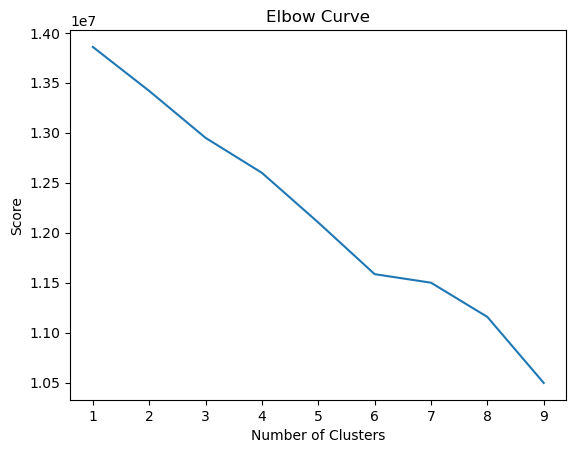

In [51]:
# Plot the elbow curve
plt.plot(num_clusters, scores)
plt.xlabel("Number of Clusters")   
plt.ylabel("Score")                
plt.title("Elbow Curve")            
plt.show()

The elbow plot shows that using 3 clusters is the best choice because it's the point where adding more clusters doesn't significantly improve the grouping of the data. After 3 clusters, the improvement slows down, meaning 3 is the most efficient number for capturing the main patterns in the data.

### 4. k-means clustering 

In [56]:
#Create the k-means object
kmeans = KMeans(n_clusters = 3)


In [58]:
# Fit the k-means object to the standardized numerical data
kmeans.fit(standardized_df)

KMeans(n_clusters=3)

In [60]:
data['clusters'] =kmeans.fit_predict(standardized_df)


In [62]:
data.head()

,Reporting Agency,Reporting Agency Code,Reporting Bureau,Reporting Bureau Code,Real Property Unique Identifier,Using Agency,Using Agency Code,Using Bureau,Using Bureau Code,US/Foreign,...,Outgrant Indicator Value,Asset Height Range,Asset Height,Asset Height Range Above Mean Sea Level,Asset Height Above Mean Sea Level,Elevation Above Mean Sea Level,FOIA Exemption,FOIA Exemption Code,Statutory Citation,clusters
0,AGRICULTURE,12,AGRICULTURAL MARKETING SERVICE,3,F02.FL6022,AGRICULTURE,12.0,AGRICULTURAL MARKETING SERVICE,3.0,UNITED STATES,...,No,NaN,NaN,NaN,NaN,NaN,No FOIA exemption,NaN,NaN,2
1,AGRICULTURE,12,AGRICULTURAL MARKETING SERVICE,3,F02.FL6028,AGRICULTURE,12.0,AGRICULTURAL MARKETING SERVICE,3.0,UNITED STATES,...,No,NaN,NaN,NaN,NaN,NaN,No FOIA exemption,NaN,NaN,2
2,AGRICULTURE,12,AGRICULTURAL MARKETING SERVICE,3,F02.FL6041,AGRICULTURE,12.0,AGRICULTURAL MARKETING SERVICE,3.0,UNITED STATES,...,No,NaN,NaN,NaN,NaN,NaN,No FOIA exemption,NaN,NaN,2
3,AGRICULTURE,12,AGRICULTURAL MARKETING SERVICE,3,F02.FL6073,AGRICULTURE,12.0,AGRICULTURAL MARKETING SERVICE,3.0,UNITED STATES,...,No,NaN,NaN,NaN,NaN,NaN,No FOIA exemption,NaN,NaN,2
4,AGRICULTURE,12,AGRICULTURAL MARKETING SERVICE,3,F02.FL6093,AGRICULTURE,12.0,AGRICULTURAL MARKETING SERVICE,3.0,UNITED STATES,...,No,NaN,NaN,NaN,NaN,NaN,No FOIA exemption,NaN,NaN,2


In [64]:
data['clusters'].value_counts()

clusters
0    186188
1     66629
2     55158
Name: count, dtype: int64

In [66]:
# Reduce data to 2 dimensions for visualization
pca = PCA(2)
reduced_data = pca.fit_transform(standardized_df)


In [68]:
# Fit the KMeans model to the reduced data
kmeans.fit(reduced_data)


KMeans(n_clusters=3)

In [70]:
# Get labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

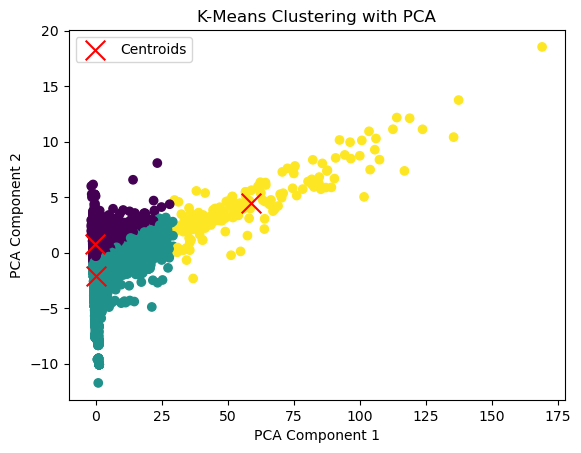

In [72]:
# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering with PCA')
plt.legend()
plt.show()


In [74]:
# Plot the clusters for Number of Federal Employees and Square Feet (Buildings)
feature_1 = 'Number of Federal Employees'
feature_2 = 'Square Feet (Buildings)'

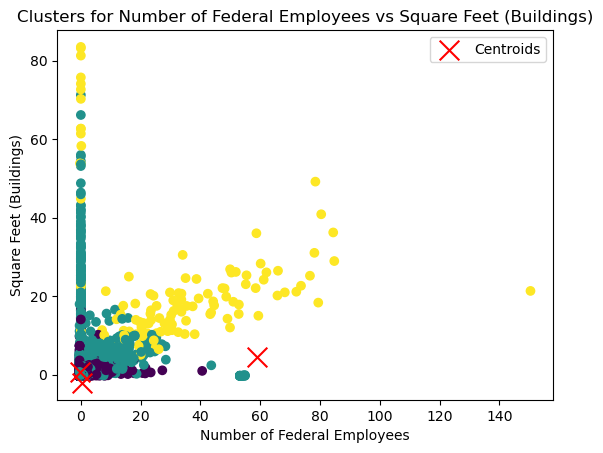

In [78]:
# Check if the feature names exist in the DataFrame
feature_1 = 'Number of Federal Employees'
feature_2 = 'Square Feet (Buildings)'

if feature_1 in standardized_df.columns and feature_2 in standardized_df.columns:
    # Plot the data points
    plt.scatter(standardized_df[feature_1], standardized_df[feature_2], c=labels, cmap='viridis', marker='o')
    
    # Check if the centers array has the correct shape
    if centers.shape[1] >= 2:
        # Plot the centroids (only if the centers array has the required dimensions)
        plt.scatter(
            centers[:, 0],  # Assuming centers[:, 0] corresponds to feature_1 in the reduced space
            centers[:, 1],  # Assuming centers[:, 1] corresponds to feature_2 in the reduced space
            c='red', marker='x', s=200, label='Centroids'
        )
    
    plt.xlabel('Number of Federal Employees')
    plt.ylabel('Square Feet (Buildings)')
    plt.title('Clusters for Number of Federal Employees vs Square Feet (Buildings)')
    plt.legend()
    plt.show()
else:
    print(f"One or both features '{feature_1}' and '{feature_2}' not found in the DataFrame.")


The clusters in the plot show logical groups of buildings based on their size and the number of employees, with each group represented by different colors. It might be helpful to look at more details or use different methods to better understand the patterns.

### 6. Descriptive statistics for the clusters using groupby()

In [82]:
# Add the cluster labels to the DataFrame
clustered_data = pd.concat([standardized_df, pd.Series(labels, name='Cluster')], axis=1)


In [84]:
# Calculate descriptive statistics for each cluster
descriptive_stats = clustered_data.groupby('Cluster').describe()


In [86]:
# Display the descriptive statistics
print(descriptive_stats)

        Reporting Agency Code                                          \
                        count      mean       std       min       25%   
Cluster                                                                 
0                    226081.0 -0.474384  0.474330 -0.706508 -0.593835   
1                     81729.0  1.310568  0.895941 -0.668951  1.284049   
2                       165.0  0.835861  0.911350 -0.668951  0.232434   

                                      Reporting Bureau Code            ...  \
              50%       75%       max                 count      mean  ...   
Cluster                                                                ...   
0       -0.593835 -0.593835  2.448338              226081.0  0.347407  ...   
1        1.509395  1.884972  2.448338               81729.0 -0.958786  ...   
2        0.232434  1.884972  2.222991                 165.0 -1.100741  ...   

        FOIA Exemption Code               Statutory Citation                \
              

Overall insights on the descriptive statistics: The clusters have distinct characteristics, shown by the differences in mean and standard deviation. This suggests that the K-Means algorithm has successfully grouped data points with similar attributes together.
The large difference in cluster sizes, especially the very small Cluster 2, may indicate that Cluster 2 is capturing outliers or rare cases in the data. Regarding Cluster Sizes, cluster 0 is the largest, while Cluster 2 is the smallest, indicating that the data points are not evenly distributed across clusters.

